## Error analysis - height
The purpose of this notebook is to analyse and visualise the erroneous height data in the sample using lazy dask routines. The notebook contains the following sections:
* Missing number analysis for whole sample
* Height data quality aggregated by country
* Height data quality aggregated by region

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import dask.dataframe as dd
import dask_geopandas as dgp
import dask

### Set up

In [4]:
parquet_dir = "./data/parquet/"

### Admininstrative areas
admin = pd.read_csv('./data/admin-codes-matches-v0.1.csv', dtype='str')
admin.drop('source', axis=1, inplace=True)

# Plot style
plt.style.use('../styles/matplotlib-stylesheets/pitayasmoothie-light.mplstyle')


### How many missing values in the sample?

In [6]:

df = dgp.read_parquet(parquet_dir, index=False)
df_non_null = df.count()
result = df_non_null.compute()

In [8]:
result

id          19840586
height      14807998
age          4891582
geometry    19840586
dtype: int64

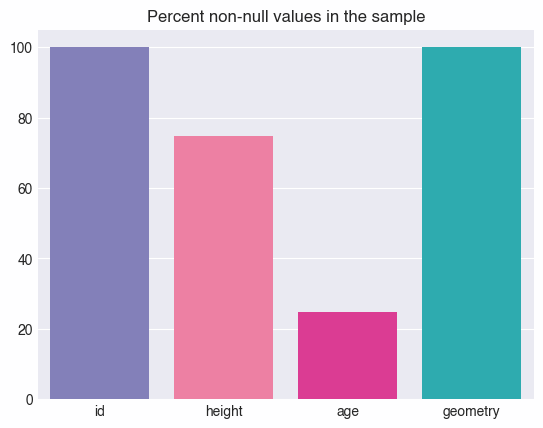

In [11]:
fig = sns.barplot(x=result.index, y=(result.values / result.id)*100);
fig.set_title("Percent non-null values in the sample");

**Figure results**: Every record of 20 Million sample has a geometry and id, but less than 80% have a height entry and 
less than 30% have an age entry.

### Where are missing and potential problematic heights?
Count different categories of height and group by country using Administrative areas (joining on the id_prefix).

Houses less than 2.5 metres in total height are not considerable habitable. This is because France, with the least stringent requirements for ceiling height, requires 2.2 metres for habitable space*, and I have allowed an additional 0.3m for the space from ceiling to roof.

**I suggest a lower cutoff of 2.5m for all structures**

*https://www.researchgate.net/publication/350969899_Housing_Spaces_in_Nine_European_Countries_A_Comparison_of_Dimensional_Requirements

In [13]:
admin.head()

,id,country,region,city
0,v0.1-AUT.4.16.24_1,austria,Oberösterreich,Pilsbach
1,v0.1-AUT.3.15.42_1,austria,Niederösterreich,Wimpassing im Schwarzatale
2,v0.1-AUT.3.15.43_1,austria,Niederösterreich,Würflach
3,v0.1-AUT.3.15.44_1,austria,Niederösterreich,Zöbern
4,v0.1-AUT.3.17.1_1,austria,Niederösterreich,Sankt Pölten


### Height categories by country: dask lazy calculation

In [172]:
def height_cat(x):
    if (x is pd.NA) or (x <= 0):
        return "invalid"
    elif x < 2.5:
        # Not habitable under 2.5 m
        return "less 2.5 m"
    elif x > 310:
        # Largest building in EU is in Poland at 310m
        return "greater 310 m"
    else:
        return "valid"
    
### Find how many records have height and age

df = dd.read_parquet("./data/parquet/", index=False, columns=["id", "height"])
df = df.astype(dtype={"id": pd.StringDtype(), "height": pd.Float32Dtype()})  
df['id_prefix'] = df.id.apply(lambda x: x.rsplit('-', maxsplit=1)[0], meta= pd.Series(dtype=pd.StringDtype()))
df_a = dd.merge(left=df[["id_prefix", "height"]], right=admin[["country","id"]], 
                     left_on="id_prefix", right_on = "id", how="left")

df_a = df_a.drop(columns=["id_prefix", "id"])

df_a["cat_height"] = df_a.height.map(height_cat, meta=pd.Series(dtype=pd.StringDtype()))

df_sum = df_a.groupby(["country", "cat_height"], sort=True).cat_height.count()
df_sum_country  = df_sum.groupby(["country"]).sum()
df_percent = df_sum / df_sum_country * 100
df_percent = df_percent.rename("percent")
df_sum = df_sum.rename("sum")

In [173]:
dfc_sum, dfc_percent = dask.compute(df_sum, df_percent)

In [215]:
## Sanity check
check = dfc_percent.groupby("country").sum()
if (check==1.0).all():
    print("All percents add to one for each country")
else:
    print("Failure to add to 100 percent for following countries")
    print(check[check!=1.0])

All ratios add to one for each country


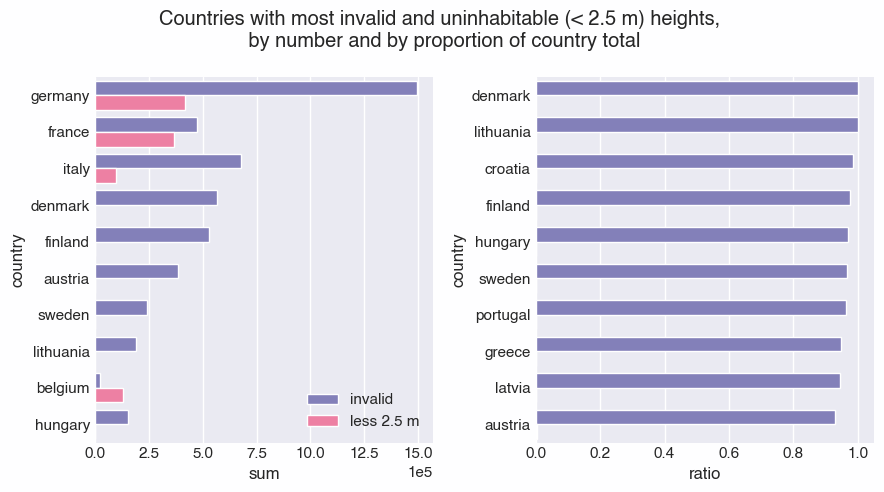

In [294]:
## Plot
fig, (ax1, ax2) = plt.subplots(1, 2, squeeze=True, figsize=(9,5))
fig.suptitle('''Countries with most invalid and uninhabitable (< 2.5 m) heights, \n by number and by proportion of country total''')


#plot 1 absolute sum
plot_df = dfc_sum.drop(labels=["valid", "greater 310 m"], level=1).reset_index()
orderby = plot_df.groupby("country", as_index=False)["sum"].sum().sort_values("sum", ascending=False)
sns.barplot(plot_df, ax=ax1, y="country", hue="cat_height", x="sum", order=orderby["country"][:10]);
ax1.legend(loc='lower right');
# Keep the scientific notation to 1e5
ax1.ticklabel_format(axis="x", style="scientific", scilimits=(5,5)); 

#plot 2 percent ratio
plot_df = dfc_percent.drop(labels=["valid","greater 310 m"], level=1).reset_index()
orderby = plot_df.groupby("country", as_index=False)["percent"].sum().sort_values("percent", ascending=False)
sns.barplot(plot_df, ax=ax2, y="country", hue="cat_height", x="percent", order=orderby["country"][:10]);
# remove legend, because it is common with the first plot and  there is no space on the graph
ax2.get_legend().remove()

plt.tight_layout()
plt.show()

Invalid heights (0m or less and null values) are most numerous in Germany and Italy in absolute numbers, but make up almost 100% of entries in Denmark and Lithuania.

Buildings that have erroneously large heights are very rare and not shown. 

The next plot shows just the occurance of heights < 2.5 m, with invalid heights removed.

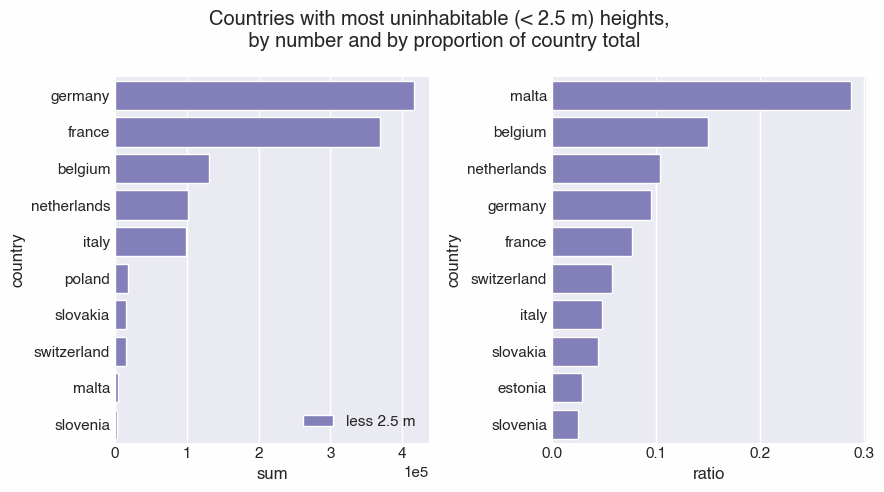

In [295]:
fig, (ax1, ax2) = plt.subplots(1, 2, squeeze=True, figsize=(9,5))
fig.suptitle('''Countries with most uninhabitable (< 2.5 m) heights, \n by number and by proportion of country total''')


#plot 1 sum
plot_df = dfc_sum.drop(labels=["valid", "invalid", "greater 310 m"], level=1).reset_index()
orderby = plot_df.groupby("country", as_index=False)["sum"].sum().sort_values("sum", ascending=False)
sns.barplot(plot_df, ax=ax1, y="country", hue="cat_height", x="sum", order=orderby["country"][:10]);
ax1.legend(loc='lower right');
# Keep the scientific notation to 1e5
ax1.ticklabel_format(axis="x", style="scientific", scilimits=(5,5)); 

#plot 2 percent
plot_df = dfc_percent.drop(labels=["valid","invalid", "greater 310 m"], level=1).reset_index()
orderby = plot_df.groupby("country", as_index=False)["percent"].sum().sort_values("percent", ascending=False)
sns.barplot(plot_df, ax=ax2, y="country", hue="cat_height", x="percent", order=orderby["country"][:10]);
# remove legend, because it is common with the first plot and  there is no space on the graph
ax2.get_legend().remove()

plt.tight_layout()
# sns.despine(left=True, bottom=True)
plt.show()

German, France, Belgium, Netherlands and Italy are in the top 10 countries for most buildings with uninhabitable height, by absolute numbers and by proportion. Let's filter for these countries and display the distribution regionally, to see if there are problem regions. For this we require a mapping to region, for which I have used the EU NUTS system. Centroids are calculated for each EUBUCCO structure and then joined on the region geometry using the "within" predicate. The use of geometries makes the dask routine slower, so I have pared it back a little for efficiency.

https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts


In [ ]:
eu_poly = gpd.read_file('NUTS_RG_20M_2021_4326.shp/NUTS_RG_20M_2021_4326.shp').query("LEVL_CODE == 2")

### Regional aggregated: Dask routine with geometry

In [93]:
# For the following operation we require dask geopandas
df = dgp.read_parquet("./data/parquet/", index=False, columns=["height", "geometry"])
df = df.astype(dtype={"height": pd.Float32Dtype()})  
df.geometry = df.centroid
df["cat_height"] = df.height.map(height_cat, meta=pd.Series(dtype=pd.StringDtype()))
df = df.drop("height", axis=1)
df = df.to_crs(epsg=4326)
df = df.sjoin(eu_poly[["geometry", "NUTS_ID"]], predicate='within')
df_sum = df[["NUTS_ID", "cat_height"]].groupby(["NUTS_ID", "cat_height"], sort=True).cat_height.count()


In [94]:
dfc_sum = df_sum.compute()

In [106]:
# Percent calculations performed outside the data-heavy dask routine
dfc_sum_NUTS = dfc_sum.groupby(["NUTS_ID"]).sum()
dfc_percent = dfc_sum / dfc_sum_NUTS * 100
dfc_percent = dfc_percent.rename("percent")
dfc_sum = dfc_sum.rename("sum")
dfc_sum_25 = dfc_sum.swaplevel()["less 2.5 m"]
dfc_percent_25 = dfc_percent.swaplevel()["less 2.5 m"]

NUTS_ID  cat_height
AL03     invalid           8
AT11     invalid       21709
         less 2.5 m        3
         valid           196
AT12     invalid       96872
                       ...  
SK04     less 2.5 m     3420
         valid         80061
TR21     invalid          10
UKN0     invalid         600
         valid             4
Name: sum, Length: 654, dtype: int64

In [14]:
## Function for quick plotting of regions as chloropleth 
def plot_map(df, variable, title, vmin=0, vmax=10000):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(figsize=(20,8))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='1%',pad=0.01)
    
    # remove the axis
    ax.axis('off')
    
    # add a title and annotation
    ax.set_title(title, fontdict={'fontsize': '15', 'fontweight' : '3'})
    
    # Create colorbar legend
    sm = plt.cm.ScalarMappable(cmap="RdPu", norm=plt.Normalize(vmin=vmin, vmax=vmax))
    fig.colorbar(sm, cax=cax, orientation='vertical', shrink=2)

    df.plot(cmap="RdPu",column=variable, linewidth=1, ax=ax, edgecolor='0.8',
                        missing_kwds={'facecolor': 'whitesmoke'}, vmin=vmin, vmax=vmax);

    ax.set_xlim(-10,30);
    ax.set_ylim(35, 65);
    plt.show()

### Plotting the regional distribution

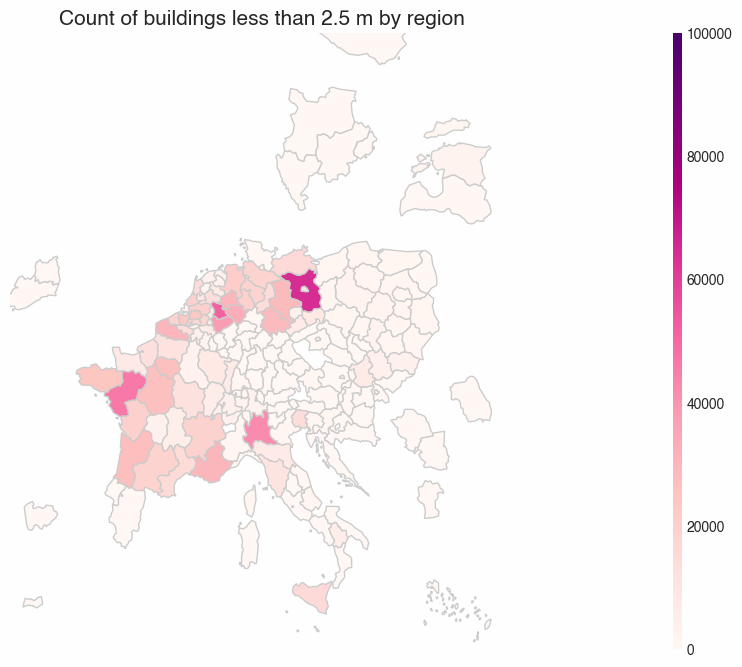

In [127]:
df_plot = eu_poly.merge(dfc_sum_25, how="right", left_on="NUTS_ID", right_index=True)[["geometry", "NUTS_NAME", "NUTS_ID", "sum"]]
plot_map(df_plot, "sum", "Count of buildings less than 2.5 m by region", vmax=100000)

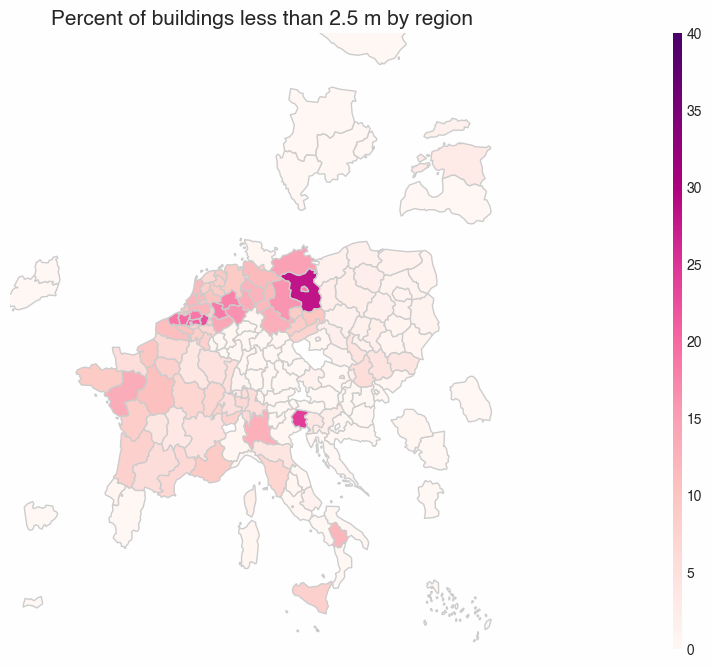

In [129]:
df_plot = eu_poly.merge(dfc_percent_25, how="right", left_on="NUTS_ID", right_index=True)[["geometry", "NUTS_NAME", "NUTS_ID", "percent"]]
plot_map(df_plot, "percent", "Percent of buildings less than 2.5 m by region", vmax=40)

Brandenburg, parts of Belgium and France have the largest proportion of buildings with < 2.5 m height. The following code produces an interactive map of the same data with plotly dash. Cannot be displayed in github directly, so use https://nbviewer.org/.

In [206]:
import plotly.express as px
from shapely import box

df_plot = eu_poly.merge(dfc_percent_25, how="right", left_on="NUTS_ID", 
                        right_index=True)[["geometry", "NUTS_NAME", "NUTS_ID", "percent"]]
df_plot = df_plot.set_index("NUTS_NAME")
df_plot.percent = df_plot.percent.round(2)

df_plot_filter = df_plot.iloc[df_plot.sindex.query(box(40, 55, -5, 30))]

fig = px.choropleth(df_plot_filter, geojson=df_plot_filter.geometry, locations=df_plot_filter.index, color='percent',
                           range_color=(0, 30),
                           color_continuous_scale = 'Reds',
                           projection = "mercator",
                           labels={'percent':'percentage height < 2.5 m', "NUTS_NAME": "Region"}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=False)
fig.show()